# Compiling Datasets, Data Inspection and Data reduction

This notebook is to make sure anyone can produce the exactly same datasets used in the paper

Please see http://astronn.readthedocs.io/en/latest/quick_start.html#folder-structure-for-astronn-apogee-and-gaia-data to setup the enviroment such that astroNN can download SDSS APOGEE data to your computer and compile the dataset.

#### To make things easier, we first continuum normalize all APOGEE DR14 stellar spectra into a single file and the array ordered in a way to correspond to DR14 allstar file. Please make sure you run this before running other notebooks

In [ ]:
import numpy as np
import time
import h5py
from astropy.io import fits

from astroNN.apogee import allstar, visit_spectra
from astroNN.datasets import xmatch
from astroNN.gaia import mag_to_fakemag
from astroNN.apogee.chips import apogee_continuum, gap_delete
from astroNN.nn.losses import mean_absolute_percentage_error

target_bit = [0, 1, 2, 3, 4, 5, 6, 7, 12]
def apstar_normalization(spectra, spectra_err, _spec_mask):
    return apogee_continuum(spectra=spectra, spectra_err=spectra_err, cont_mask=None, deg=2, dr=14, bitmask=_spec_mask, target_bit=target_bit)

allstar_data = fits.getdata(allstar(dr=14))

start_time = time.time()

total_num = allstar_data['RA'].shape[0]
spec = np.zeros((total_num, 7514), dtype=np.float32)

for counter in range(0, total_num):
    if allstar_data['LOCATION_ID'][counter] == 1:
        continue
    ap_path = visit_spectra(dr=14, apogee=allstar_data['APOGEE_ID'][counter], 
                            location=allstar_data['LOCATION_ID'][counter], verbose=0)
    if ap_path is False:
        pass
    else:
        apstar_file = fits.open(ap_path)
        nvisits = apstar_file[0].header['NVISITS']
        if nvisits == 1:
            _spec = apstar_file[1].data
            _spec_err = apstar_file[2].data
            _spec_mask = apstar_file[3].data
        else:
            _spec = apstar_file[1].data[1]
            _spec_err = apstar_file[2].data[1]
            _spec_mask = apstar_file[3].data[1]
        
        if not np.all(_spec==0.):
            _spec, _spec_err = apstar_normalization(_spec, _spec_err, _spec_mask)
            spec[counter] = _spec

    if counter % 1000 == 0:
        print(f'Completed {counter} of {total_num}, {(time.time() - start_time):.{2}f}s elapsed')
        
# save a fits
hdu = fits.PrimaryHDU(spec)
hdu.writeto('contspec_dr14.fits')

#### Then we compile training set and testing sets

`astroNN_apogee_dr14_catalog.fits` is available at https://github.com/henrysky/astroNN_spectra_paper_figures/raw/master/astroNN_apogee_dr14_catalog.fits

In [ ]:
import h5py
import numpy as np
from astropy.io import fits

from astroNN.apogee import allstar
from astroNN.gaia import mag_to_fakemag, extinction_correction, fakemag_to_logsol

file = fits.open("contspec_dr14.fits")
allstar_file = fits.getdata(allstar(dr=14))
gaia_data_file = fits.getdata("apogeedr14_gaiadr2_xmatch.fits")
astroNN_data_file = fits.getdata("astroNN_apogee_dr14_catalog.fits")
all_spec = file[0].data

extinction = allstar_file['AK_TARG']
extinction[extinction < 0.] = -9999  # assume corrupted extinction if negative extinction
ra = gaia_data_file['RA']
dec = gaia_data_file['DEC']
parallax = gaia_data_file['parallax']
parallax_error = gaia_data_file['parallax_error']
visibility_periods_used = gaia_data_file['visibility_periods_used']
teff = astroNN_data_file['astroNN'][:, 0]

# if extinction_method is IRAC then flag it as good, otherwise not good
extinction_method = np.zeros_like(ra)
extinction_method[allstar_file['AK_TARG_METHOD'] == 'RJCE_IRAC'] = 1

corrected_K = extinction_correction(allstar_file['K'], extinction)
fakemag, fakemag_error = mag_to_fakemag(corrected_K, parallax, parallax_error)
logsol = fakemag_to_logsol(fakemag)

# cutting criteria for training set
good_idx = ((parallax != -9999.) & (parallax_error < 0.1) & (allstar_file['SNR'] > 200) &
            (corrected_K != -9999) & (visibility_periods_used > 10) & 
            np.all(all_spec != 0., axis=1) & (allstar_file['vscatter'] < 1.) & (allstar_file['STARFLAG'] == 0) & ((logsol > 0) | (parallax < 0)))

# cutting criteria for testing set
good_test_idx = ((parallax != -9999.) & (parallax_error < 0.1) & (allstar_file['SNR'] < 200) & 
                 (corrected_K != -9999) & (visibility_periods_used > 10) &
                 np.all(all_spec != 0., axis=1) & (allstar_file['vscatter'] < 1.) & (allstar_file['STARFLAG'] == 0) & ((logsol > 0) | (parallax < 0)))

print("Training Set Spectra: ", np.sum(good_idx))
print("Low SNR Combined Spectra Testing Set Spectra: ", np.sum(good_test_idx))

h5f = h5py.File('gaia_dr2_train.h5', 'w')
h5f.create_dataset('spectra', data=all_spec[good_idx])
h5f.create_dataset('RA', data=allstar_file['RA'][good_idx])
h5f.create_dataset('DEC', data=allstar_file['DEC'][good_idx])
h5f.create_dataset('SNR', data=allstar_file['SNR'][good_idx])
h5f.create_dataset('allstar_idx', data=np.arange(allstar_file['RA'].shape[0])[good_idx])
h5f.create_dataset('ASPCAP_TEFF', data=allstar_file['TEFF'][good_idx])
h5f.create_dataset('ASPCAP_LOGG', data=allstar_file['LOGG'][good_idx])
h5f.create_dataset('fakemag', data=fakemag[good_idx])
h5f.create_dataset('fakemag_err', data=fakemag_error[good_idx])
h5f.create_dataset('corrected_K', data=corrected_K[good_idx])  # extinction corrected
h5f.create_dataset('extinction', data=extinction[good_idx])
h5f.create_dataset('extinction_method', data=extinction_method[good_idx])
h5f.create_dataset('parallax', data=parallax[good_idx])
h5f.create_dataset('parallax_err', data=parallax_error[good_idx])
h5f.create_dataset('bp_rp', data=gaia_data_file['bp_rp'][good_idx])
h5f.create_dataset('phot_g_mean_mag', data=gaia_data_file['phot_g_mean_mag'][good_idx])
h5f.create_dataset('NN_teff', data=teff[good_idx])
h5f.close()

h5f = h5py.File('gaia_dr2_test.h5', 'w')
h5f.create_dataset('spectra', data=all_spec[good_test_idx])
h5f.create_dataset('RA', data=allstar_file['RA'][good_test_idx])
h5f.create_dataset('DEC', data=allstar_file['DEC'][good_test_idx])
h5f.create_dataset('SNR', data=allstar_file['SNR'][good_test_idx])
h5f.create_dataset('allstar_idx', data=np.arange(allstar_file['RA'].shape[0])[good_test_idx])
h5f.create_dataset('ASPCAP_TEFF', data=allstar_file['TEFF'][good_test_idx])
h5f.create_dataset('ASPCAP_LOGG', data=allstar_file['LOGG'][good_test_idx])
h5f.create_dataset('fakemag', data=fakemag[good_test_idx])
h5f.create_dataset('fakemag_err', data=fakemag_error[good_test_idx])
h5f.create_dataset('corrected_K', data=corrected_K[good_test_idx])  # extinction corrected
h5f.create_dataset('extinction', data=extinction[good_test_idx])
h5f.create_dataset('extinction_method', data=extinction_method[good_test_idx])
h5f.create_dataset('parallax', data=parallax[good_test_idx])
h5f.create_dataset('parallax_err', data=parallax_error[good_test_idx])
h5f.create_dataset('bp_rp', data=gaia_data_file['bp_rp'][good_test_idx])
h5f.create_dataset('phot_g_mean_mag', data=gaia_data_file['phot_g_mean_mag'][good_test_idx])
h5f.create_dataset('NN_teff', data=teff[good_test_idx])
h5f.close()

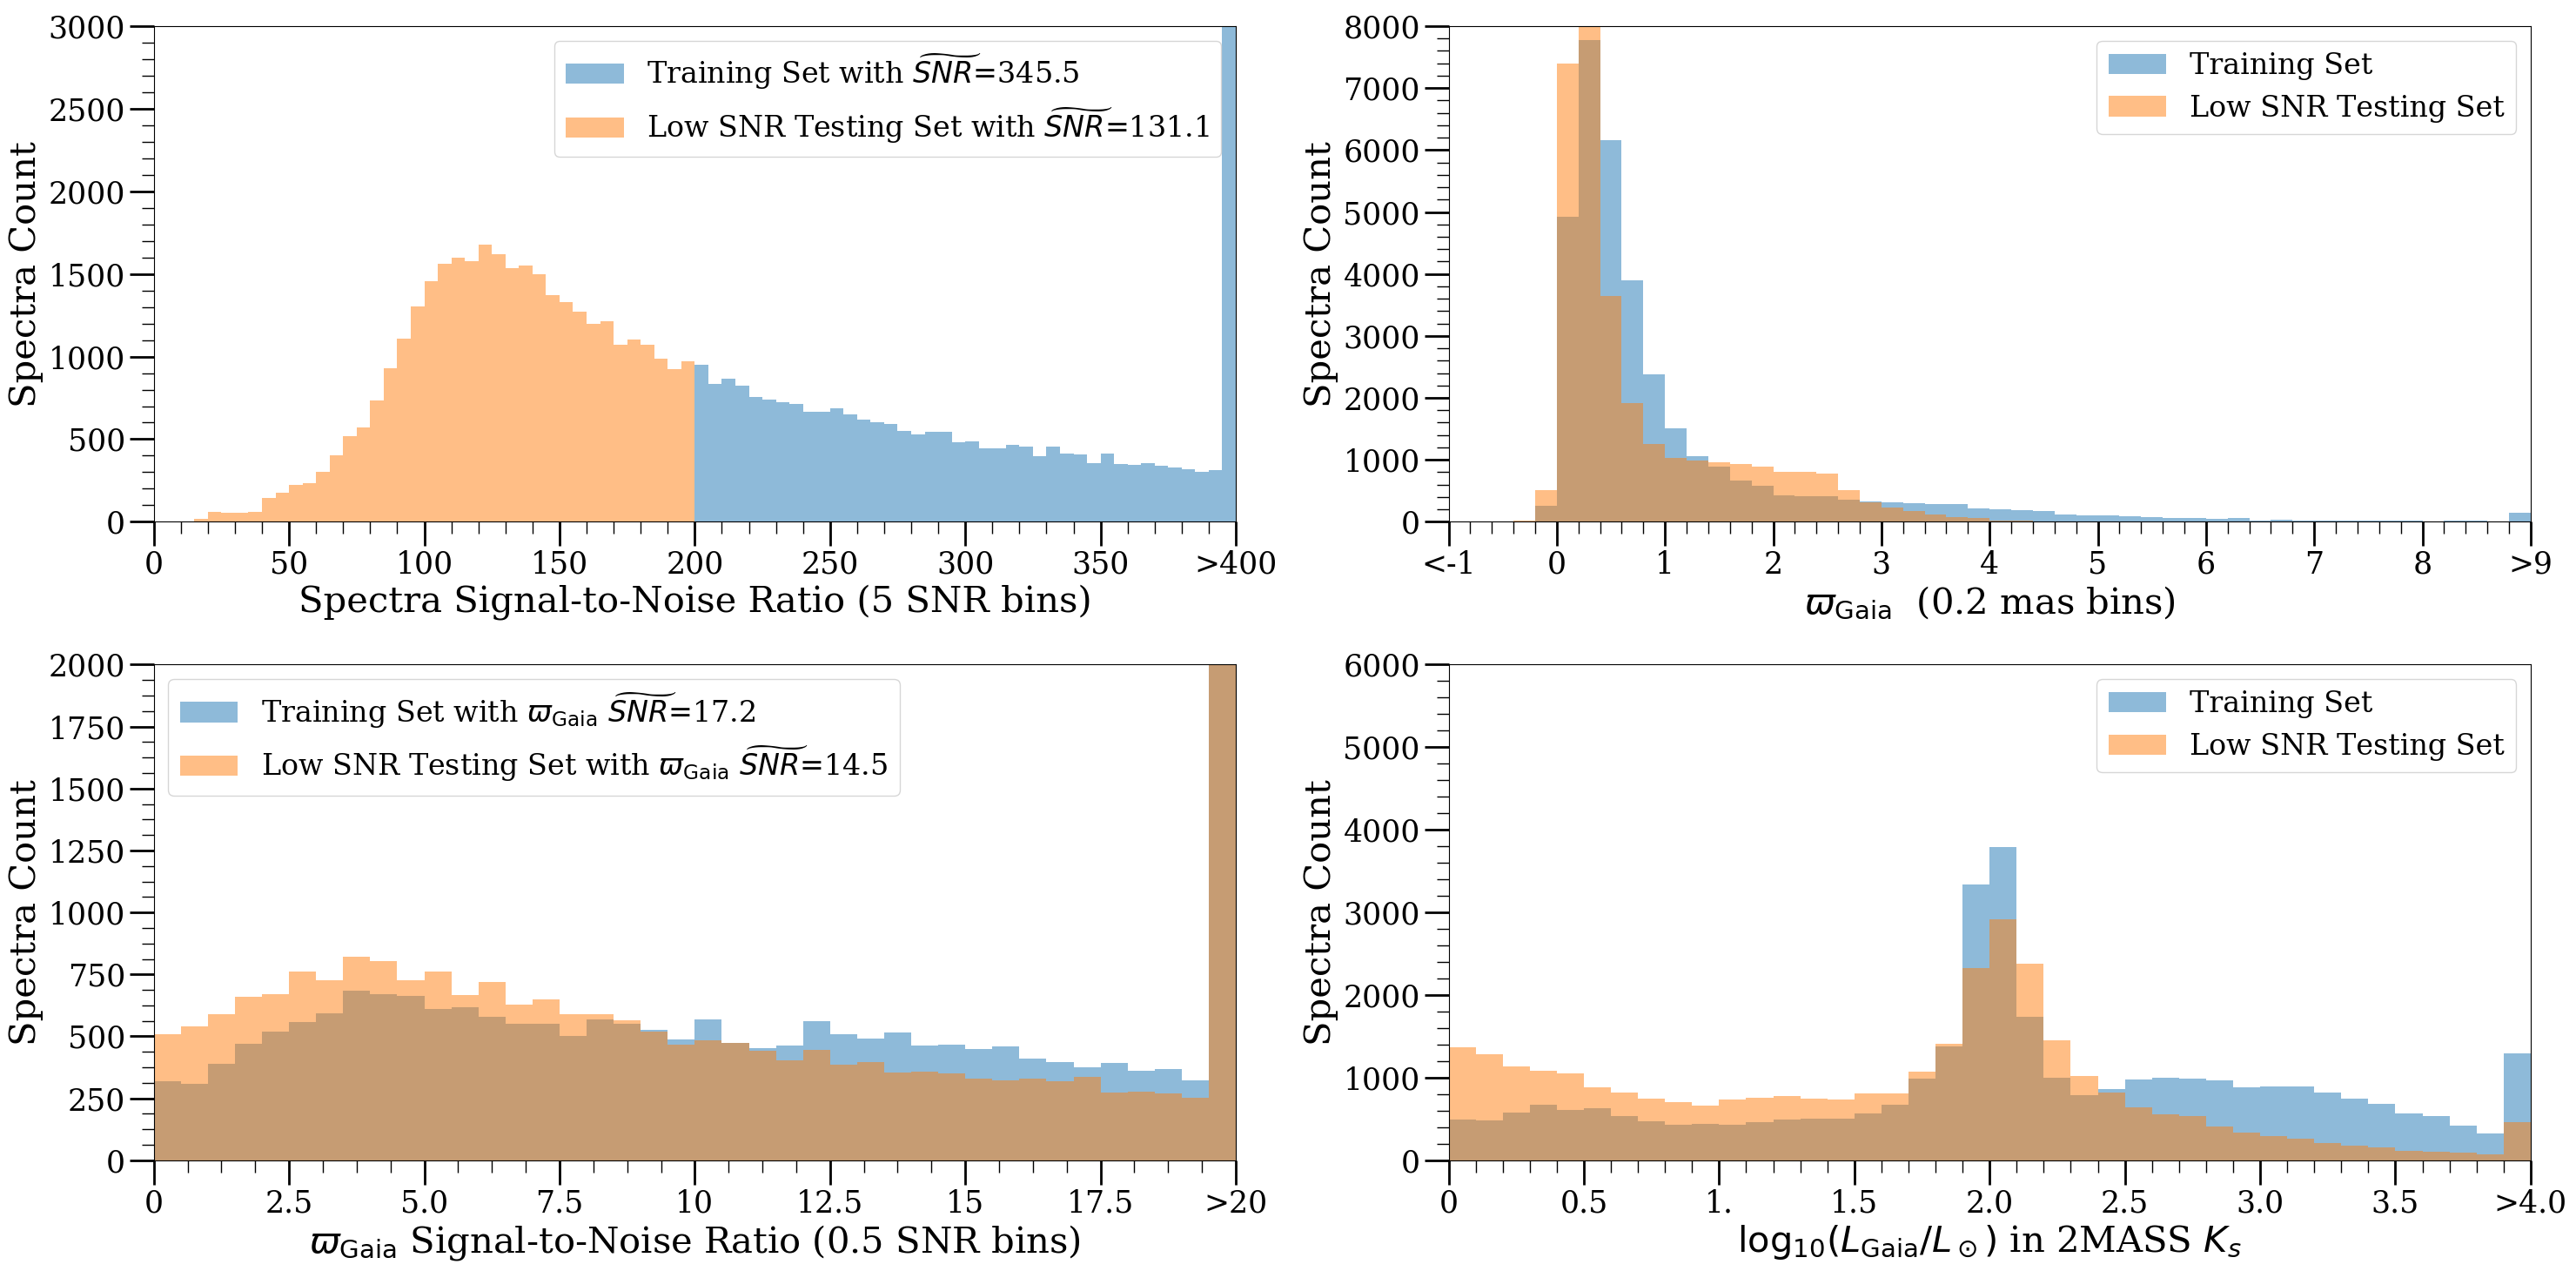

In [1]:
%matplotlib inline
import h5py
import pylab as plt
import numpy as np
from astroNN.gaia import gaiadr2_parallax, fakemag_to_logsol

plt.rc('font',**{'family': 'serif', 'weight':'medium', 'size':20})

train_h5 = h5py.File('gaia_dr2_train.h5', 'r')
test_combined_h5 = h5py.File('gaia_dr2_test.h5', 'r')

upper_bound = 400  # if SNR higher than 400, count it as  400
train_SNR = train_h5['SNR']
test_combined_SNR = test_combined_h5['SNR']

fig, ((ax1, ax3), (ax2, ax4)) = plt.subplots(2, 2, figsize=(30,15), dpi=100)

ax1.hist(np.clip(train_SNR, 0, upper_bound), 80, range=(0, upper_bound), alpha=0.5, 
         label=r'Training Set with $\widetilde{SNR}$=' + f'{np.median(train_SNR):.1f}')
ax1.hist(test_combined_SNR, 80, range=(0, upper_bound), alpha=0.5, 
         label=r'Low SNR Testing Set with $\widetilde{SNR}$=' + f'{np.median(test_combined_SNR):.1f}')
# plt.hist(parallax_snr, 40, range=(0, upper_bound), alpha=0.5, label='Individual Spectra Testing set')
ax1.set_xlabel('Spectra Signal-to-Noise Ratio (5 SNR bins)', fontsize=30)
ax1.set_ylabel('Spectra Count', fontsize=30)
ax1.set_ylim((0, 3000))
ax1.set_xlim((0, upper_bound))
ax1.legend(loc='best', fontsize=24)
ax1.minorticks_on()
ax1.set_xticklabels(['0', '50', '100', '150', '200', '250', '300', '350', '>400'])
ax1.tick_params(labelsize=25, width=2, length=20, which='major')
ax1.tick_params(width=1, length=10, which='minor')
                                                                   
upper_bound = 20  # if SNR higher than 20, count it as  20
train_SNR = np.array(np.abs(train_h5['parallax'])) / np.array(train_h5['parallax_err'])
test_combined_SNR = np.array(np.abs(test_combined_h5['parallax'])) / np.array(test_combined_h5['parallax_err'])

ax2.hist(np.clip(train_SNR, 0, upper_bound), 40, range=(0, upper_bound), alpha=0.5, 
         label=r'Training Set with $\varpi_{\mathrm{Gaia}}$ $\widetilde{SNR}$=' + 
         f'{np.median(train_SNR):.1f}')
ax2.hist(np.clip(test_combined_SNR, 0, upper_bound), 40, range=(0, upper_bound), alpha=0.5, 
         label=r'Low SNR Testing Set with $\varpi_{\mathrm{Gaia}}$ $\widetilde{SNR}$=' + 
         f'{np.median(test_combined_SNR):.1f}')
# plt.hist(parallax_snr, 40, range=(0, upper_bound), alpha=0.5, label='Individual Spectra Testing set')
ax2.set_xlabel(r'$ \varpi_{\mathrm{Gaia}}$' + ' Signal-to-Noise Ratio (0.5 SNR bins)', fontsize=30)
ax2.set_ylabel('Spectra Count', fontsize=30)
ax2.set_ylim((0, 2000))
ax2.set_xlim((0, upper_bound))
ax2.legend(loc='best', fontsize=24)
ax2.minorticks_on()
ax2.set_xticklabels(['0', '2.5', '5.0', '7.5', '10', '12.5', '15', '17.5', '>20'])
ax2.tick_params(labelsize=25, width=2, length=20, which='major')
ax2.tick_params(width=1, length=10, which='minor')

lower_bound = -1.  # if parallax lower than -1., count it as  -1.
upper_bound = 9.  # if parallax higher than 10, count it as  10
ax3.hist(np.clip(train_h5['parallax'], lower_bound, upper_bound), 50, range=(lower_bound, upper_bound), alpha=0.5, 
         label=r'Training Set')
ax3.hist(np.clip(test_combined_h5['parallax'], lower_bound, upper_bound), 50, range=(lower_bound, upper_bound), alpha=0.5, 
         label=r'Low SNR Testing Set')
# plt.hist(parallax_snr, 40, range=(0, upper_bound), alpha=0.5, label='Individual Spectra Testing set')
ax3.set_xlabel(r'$ \varpi_{\mathrm{Gaia}}$  (0.2 mas bins)', fontsize=30)
ax3.set_ylabel('Spectra Count', fontsize=30)
ax3.set_ylim((0, 8000))
ax3.legend(loc='best', fontsize=24)
ax3.minorticks_on()
ax3.set_xticks([-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
ax3.set_xticklabels(['<-1', '0', '1', '2', '3', '4', '5', '6', '7', '8', '>9'])
ax3.set_xlim((lower_bound, upper_bound))
ax3.tick_params(labelsize=25, width=2, length=20, which='major')
ax3.tick_params(width=1, length=10, which='minor')

train_logsol = fakemag_to_logsol(train_h5['fakemag'][np.array(train_h5['fakemag']) > 0.])
test_logsol = fakemag_to_logsol(test_combined_h5['fakemag'][np.array(test_combined_h5['fakemag']) > 0.])
lower_bound = 0.  # if fakemag lower than 0., count it as  0.
upper_bound = 4.  # if fakemag higher than 25, count it as  25
ax4.hist(np.clip(train_logsol, lower_bound, upper_bound), 40, range=(lower_bound, upper_bound), alpha=0.5, 
         label=r'Training Set')
ax4.hist(np.clip(test_logsol, lower_bound, upper_bound), 40, range=(lower_bound, upper_bound), alpha=0.5, 
         label=r'Low SNR Testing Set')
# plt.hist(parallax_snr, 40, range=(0, upper_bound), alpha=0.5, label='Individual Spectra Testing set')
ax4.set_xlabel(r"$\log_{10} (L_\mathrm{Gaia} /L_\odot)$" + " in 2MASS " + r"$K_{s}$", fontsize=30)
ax4.set_ylabel('Spectra Count', fontsize=30)
ax4.set_ylim((0, 6000))
ax4.set_xlim((lower_bound, upper_bound))
ax4.legend(loc='best', fontsize=24)
ax4.minorticks_on()
ax4.set_xticklabels(['0', '0.5', '1.', '1.5', '2.0', '2.5', '3.0', '3.5', '>4.0'])
ax4.tick_params(labelsize=25, width=2, length=20, which='major')
ax4.tick_params(width=1, length=10, which='minor')

plt.tight_layout()
plt.savefig('SNR_traintest.pdf')

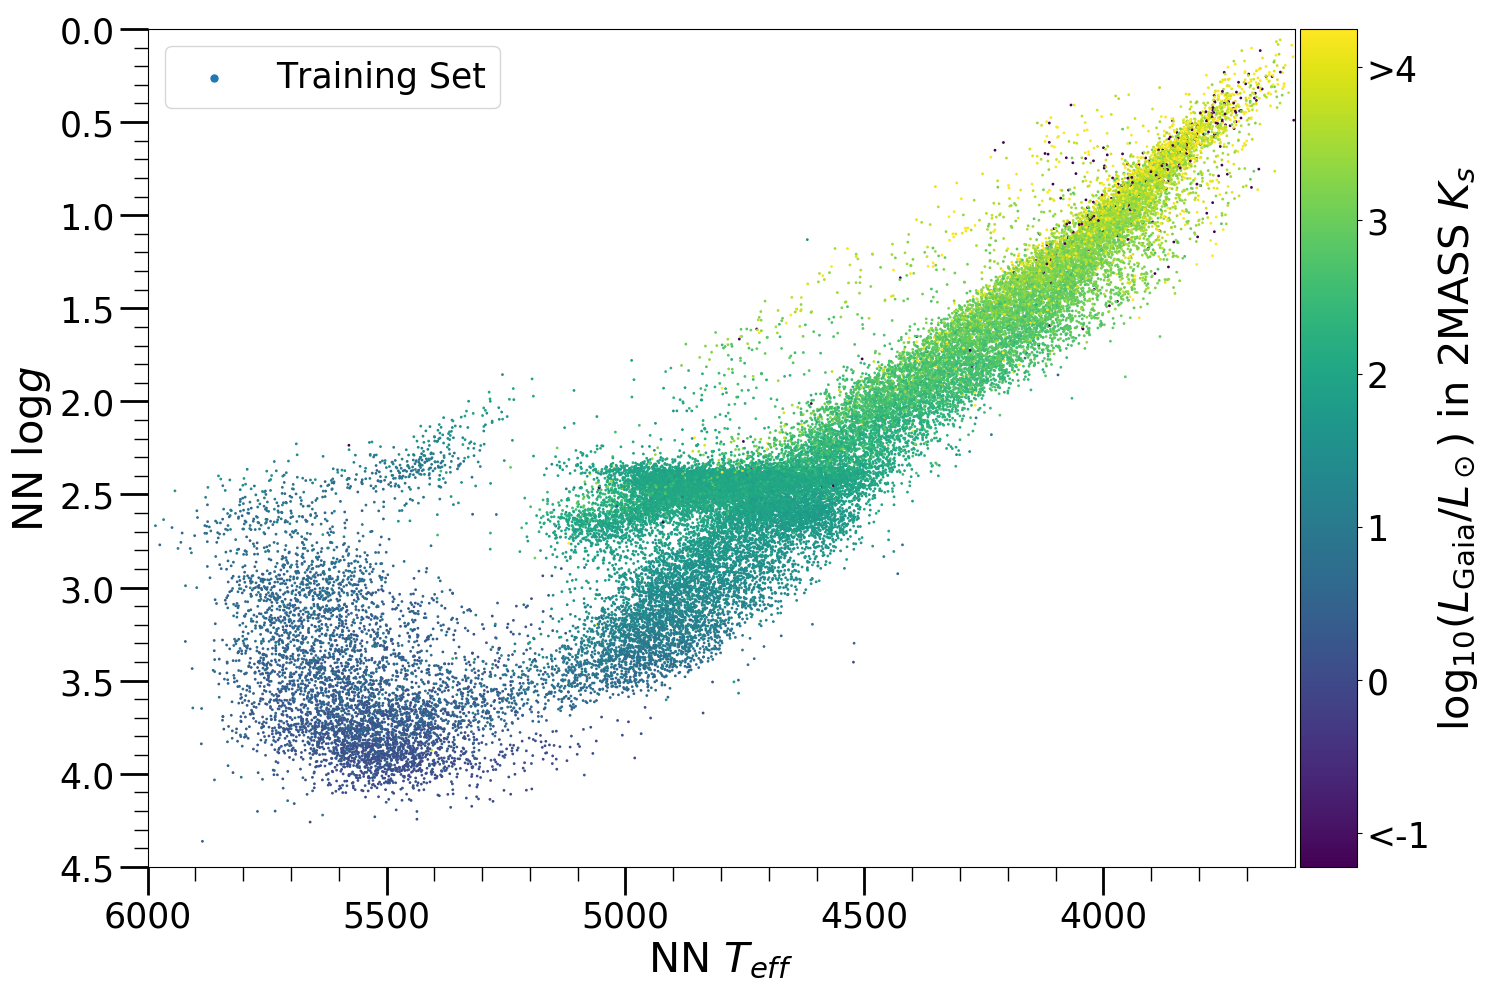

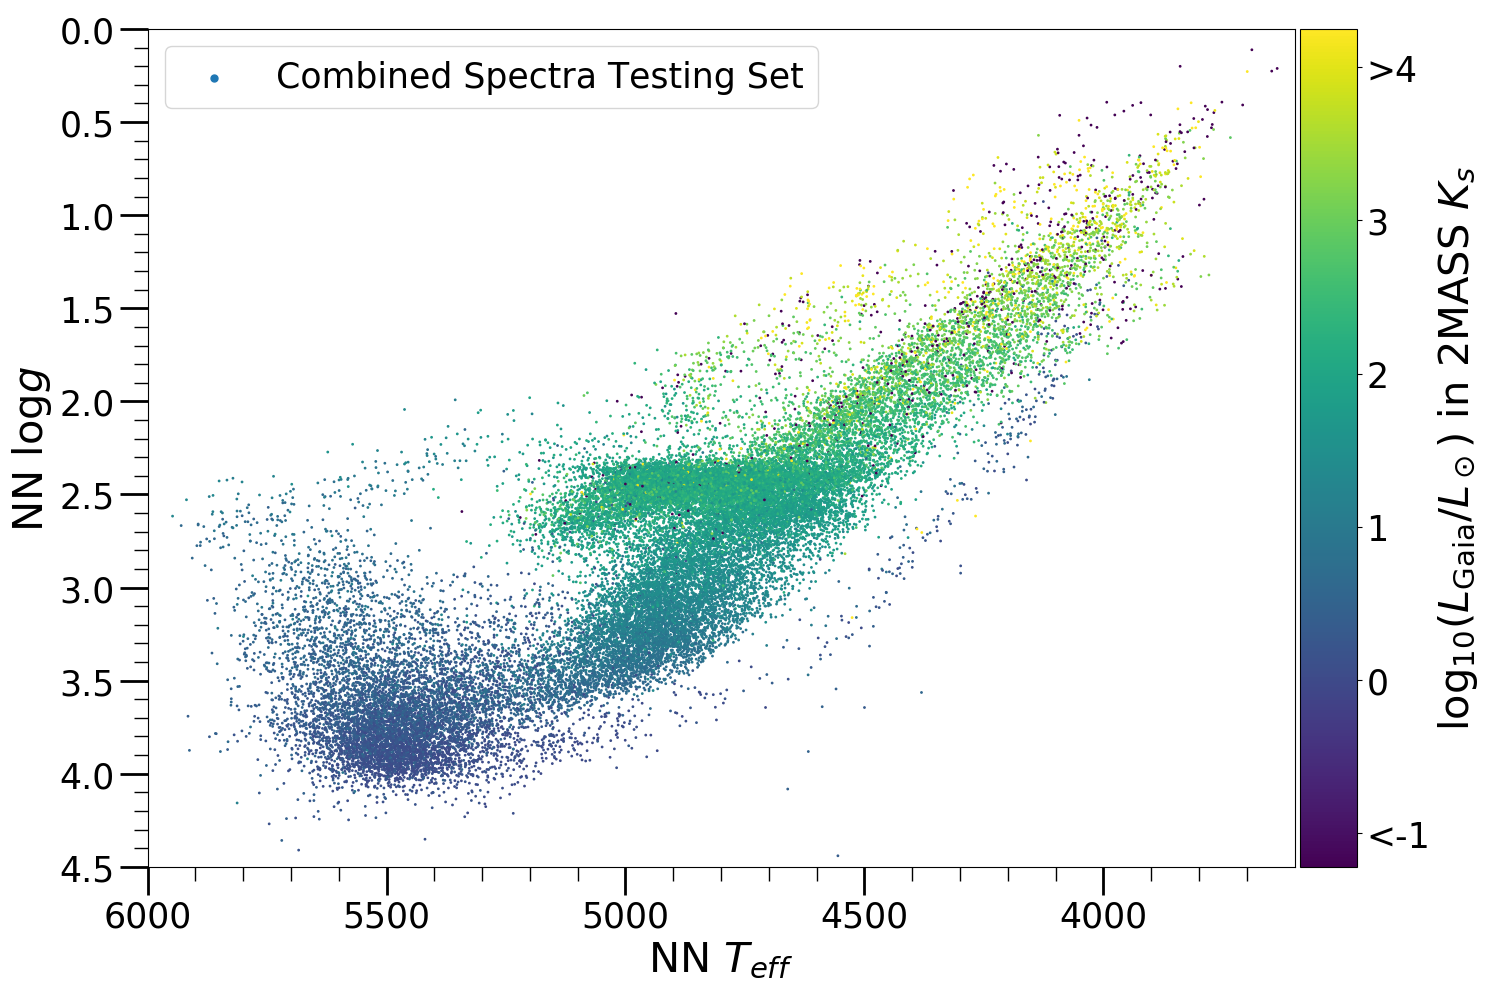

In [1]:
%matplotlib inline
import h5py
import pylab as plt
import numpy as np
from astropy.io import fits
from astroNN.apogee import allstar
from astroNN.datasets import xmatch
from astroNN.gaia import fakemag_to_logsol
from mpl_toolkits.axes_grid1 import make_axes_locatable

f_chem = fits.getdata("astroNN_apogee_dr14_catalog.fits")
allstar_RA = f_chem['RA']
allstar_DEC = f_chem['DEC']

nn_teff = f_chem['astroNN'][:, 0]
nn_teff_error = f_chem['astroNN_error'][:, 0]
nn_logg = f_chem['astroNN'][:, 1]
nn_logg_error = f_chem['astroNN_error'][:, 1]

train_h5 = h5py.File('gaia_dr2_train.h5', 'r')
test_combined_h5 = h5py.File('gaia_dr2_test.h5', 'r')

train_RA = np.array(train_h5['RA'])
train_DEC = np.array(train_h5['DEC'])
train_fakemag = np.array(train_h5['fakemag'])
test_combined_RA = np.array(test_combined_h5['RA'])
test_combined_DEC = np.array(test_combined_h5['DEC'])
test_combined_fakemag = np.array(test_combined_h5['fakemag'])

idx_train_1, idx_train_2, sep = xmatch(allstar_RA, train_RA, colRA1=allstar_RA, colDec1=allstar_DEC, 
                                       colRA2=train_RA, colDec2=train_DEC, swap=False)

idx_test_combined_1, idx_test_combined_2, sep = xmatch(allstar_RA, test_combined_RA, colRA1=allstar_RA, colDec1=allstar_DEC, 
                                                       colRA2=test_combined_RA, colDec2=test_combined_DEC, swap=False)

fig = plt.figure(figsize=(15, 10), dpi=100)
ax = plt.gca()
plt.scatter(nn_teff[idx_train_1], nn_logg[idx_train_1], s=1., 
            c=np.clip(fakemag_to_logsol(train_fakemag[idx_train_2]), -1.22, 4.25), rasterized=True, label='Training Set')
plt.xlabel('NN ' + "$T_{eff}$", fontsize=30)
plt.ylabel('NN ' + '$\log{g}$', fontsize=30)
plt.xlim((3600., 6000))
plt.ylim((0.0, 4.5))
plt.legend(loc='best', fontsize=25, markerscale=5)
plt.minorticks_on()
plt.tick_params(labelsize=25, width=2, length=20, which='major')
plt.tick_params(width=1, length=10, which='minor')
ax.invert_xaxis()
ax.invert_yaxis()
# colorbar 
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(cax=cax)
cbar.ax.set_yticklabels(["<-1", "0", "1", "2", "3", ">4"])
cbar.ax.tick_params(labelsize=25)
cbar.set_label(r"$\log_{10} (L_\mathrm{Gaia} /L_\odot)$ in 2MASS $K_{s}$", size=30)
plt.tight_layout()
# plt.savefig('logg_teff_fe_tefferr.pdf')
plt.show()

fig = plt.figure(figsize=(15, 10), dpi=100)
ax = plt.gca()
plt.scatter(nn_teff[idx_test_combined_1], nn_logg[idx_test_combined_1], s=1., 
            c=np.clip(fakemag_to_logsol(test_combined_fakemag[idx_test_combined_2]), -1.22, 4.25), 
            rasterized=True, label='Combined Spectra Testing Set')
plt.xlabel('NN ' + "$T_{eff}$", fontsize=30)
plt.ylabel('NN ' + '$\log{g}$', fontsize=30)
plt.xlim((3600., 6000))
plt.ylim((0.0, 4.5))
plt.legend(loc='best', fontsize=25, markerscale=5)
plt.minorticks_on()
plt.tick_params(labelsize=25, width=2, length=20, which='major')
plt.tick_params(width=1, length=10, which='minor')
ax.invert_xaxis()
ax.invert_yaxis()
# colorbar 
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(cax=cax)
cbar.ax.set_yticklabels(["<-1", "0", "1", "2", "3", ">4"])
cbar.ax.tick_params(labelsize=25)
cbar.set_label(r"$\log_{10} (L_\mathrm{Gaia} /L_\odot)$ in 2MASS $K_{s}$", size=30)
plt.tight_layout()
# plt.savefig('logg_teff_fe_tefferr.pdf')
plt.show()

This is Gaia DR2 - APOGEE DR14 matched parallax, RA DEC in J2015.5, parallax in mas


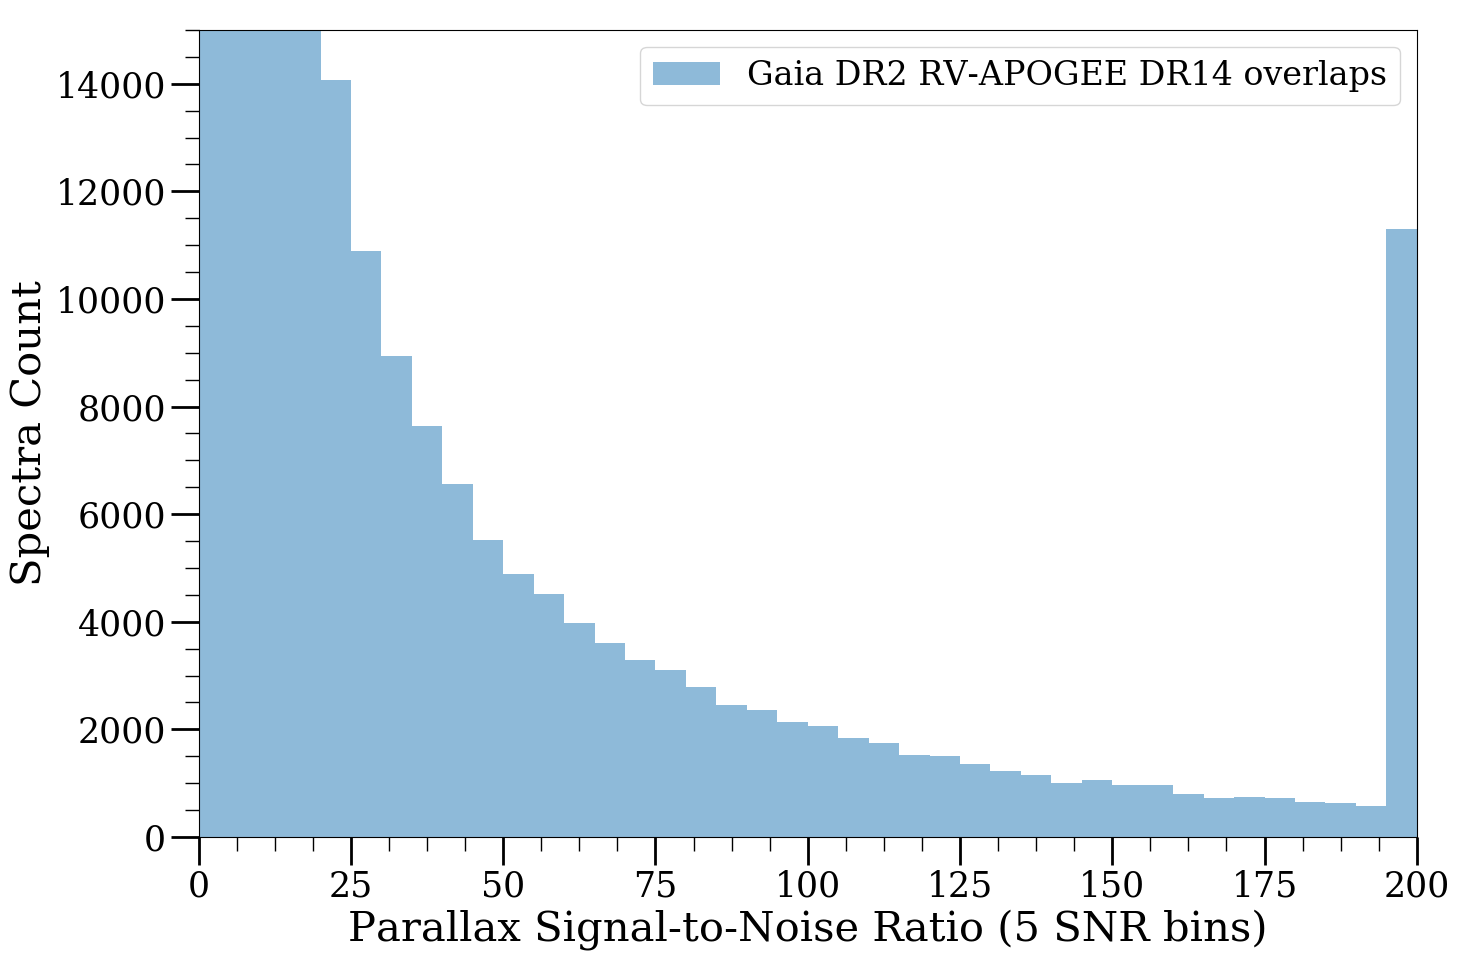

In [5]:
%matplotlib inline
import pylab as plt
import numpy as np
from astroNN.gaia import gaiadr2_parallax

plt.rc('font',**{'family': 'serif', 'weight':'medium', 'size':20})

ra, dec, parallax, parallax_error = gaiadr2_parallax(cuts=False, keepdims=False)

upper_bound = 200  # if SNR higher than 200, count it as  200
parallax_snr = parallax / parallax_error
parallax_snr[parallax_snr>upper_bound] = upper_bound

plt.figure(figsize=(15,10), dpi=100)
plt.hist(parallax_snr, 40, range=(0, upper_bound), alpha=0.5, label='Gaia DR2 RV-APOGEE DR14 overlaps')
plt.xlabel('Parallax Signal-to-Noise Ratio (5 SNR bins)', fontsize=30)
plt.ylabel('Spectra Count', fontsize=30)
plt.ylim((0, 15000))
plt.xlim((0, upper_bound))
plt.legend(loc='best', fontsize=24)
plt.minorticks_on()
plt.tick_params(labelsize=25, width=2, length=20, which='major')
plt.tick_params(width=1, length=10, which='minor')
plt.tight_layout()
plt.savefig('SNR_APOGEE_DR2RV.pdf')
plt.show()